# This notebook explores a variety of training methods

## Imports 
<hr>

In [1]:
# %matplotlib widget
import numpy as np 
import matplotlib.pyplot as plt 
import math
import pandas as pd
from datetime import datetime

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from score_regression import compute_scores

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.svm import SVR

In [4]:
def plotRegression(truth, pred):
    plt.figure(figsize=(10,10))
    plt.scatter(truth, pred)
    plt.grid()
    plt.xlabel("Truth")
    plt.ylabel("Predicted")
    plt.title("Truth Plotted against actual value")
    plt.plot([min(truth),max(truth)], [min(truth),max(truth)], 'r')
    plt.show()
    
def computeAverageError(pred, y):
    err = []
    for i in range(len(pred)):
        err.append(abs((y[i] - pred[i])/(y[i] + 1e-6)))
    return sum(err)/ len(err)

## Load the data and split into training and testing 
<hr>

In [5]:
############## This data has not been normalized/scaled at all ###################
dataUnscaled_filename = '/Users/brad/Desktop/CS6620/Project/Data/combined_processed_data1.csv' 
data = pd.read_csv(dataUnscaled_filename, sep=',')

In [6]:
# transform zenith, azimuth, month to polar
data['sine_zenith'] = data['Zenith'].apply(lambda val: np.sin(val*math.pi/180))
data['cos_zenith'] = data['Zenith'].apply(lambda val: np.cos(val*math.pi/180))
data['sine_azimuth'] = data['Azimuth'].apply(lambda val: np.sin(val*math.pi/180))
data['cos_azimuth'] = data['Azimuth'].apply(lambda val: np.cos(val*math.pi/180))
data['sine_month'] = data['Month'].apply(lambda mon: np.sin(mon*math.pi/12))
data['cos_month'] = data['Month'].apply(lambda mon: np.cos(mon*math.pi/12))
data['cos_day'] = np.cos(pd.DatetimeIndex(data['date_time']).dayofyear*math.pi/180)
data['sin_day'] = np.sin(pd.DatetimeIndex(data['date_time']).dayofyear*math.pi/180)
# data.drop(['Zenith', 'Elevation', 'Azimuth', 'Month'], axis=1, inplace=True)

In [7]:
# # warm season
# data = data.loc[(data['Month'] >= 4) & (data['Month'] <= 9)]
# cold season
# cold_season = data.loc[(data['Month'] < 4)]
# cold_season = cold_season.append(data.loc[(data['Month'] > 9)], ignore_index= True)
# data = cold_season


y = data['Solar_average'].to_numpy()
x = data.drop(['Unnamed: 0', 'date_time', 'Solar_average', 'Solar_total', 'Count', 'date_time', 'Solar_average', 'Solar_total', 'Count', 'Month', 'Day', 'Zenith', 'Elevation', 'Azimuth'], axis=1).to_numpy()
train_length = int(x.shape[0] * 0.85)
x_train = x[0 : train_length].reshape(-1, x.shape[1])
y_train = y[0 : train_length].reshape(-1,1)
x_test = x[train_length : ].reshape(-1, x.shape[1])
y_test = y[train_length : ].reshape(-1,1)
print('After split and reshape')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

After split and reshape
(4603, 43)
(4603, 1)
(813, 43)
(813, 1)


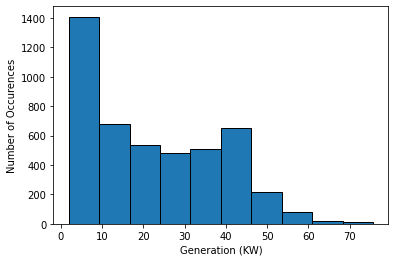

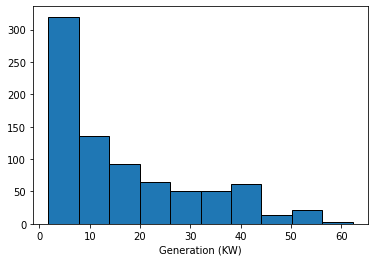

In [8]:
plt.figure()
plt.hist(y_train/1000, edgecolor='black')
# plt.title("Training 'y' distribution")
plt.xlabel('Generation (KW)')
plt.ylabel("Number of Occurences")
plt.show()
plt.figure()
plt.hist(y_test/1000, edgecolor='black')
# plt.title("Test 'y' distribution")
plt.xlabel('Generation (KW)')
plt.show()

## Explore different methods of scaling 
<hr>

In [9]:
# Scale 
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# x_train = sc_X.fit_transform(x_train)
# x_test = sc_X.fit_transform(x_test)
# y_train = sc_y.fit_transform(y_train)
# y_test = sc_y.fit_transform(y_test)

In [10]:
# # MinMaxScale a different way
# scalerX = MinMaxScaler()
# scalerY = MinMaxScaler()
# x_train = scalerX.fit_transform(x_train)
# x_test = scalerX.fit_transform(x_test)
# y_train = scalerY.fit_transform(y_train)
# y_test = scalerY.fit_transform(y_test)

In [11]:
# Best results came from using quantile uniform 

# scalerX = QuantileTransformer(output_distribution='uniform')
scalerX = MinMaxScaler()
scalerX.fit(x_train)
x_train = scalerX.transform(x_train)
x_test = scalerX.transform(x_test)

scalerY = QuantileTransformer(output_distribution='uniform')
scalerY.fit(y_train)
y_train = scalerY.transform(y_train)
y_test = scalerY.transform(y_test)



In [12]:
# Unscale and score 
def score_unscaled(truth, pred):
    scores =  compute_scores(scalerY.inverse_transform(truth.reshape(-1,1))/1000, scalerY.inverse_transform(pred.reshape(-1,1))/1000)
    scores['RMSE'] = np.sqrt(scores['MSE'])
    scores['MAPE'] = computeAverageError(scalerY.inverse_transform(truth.reshape(-1,1))/1000, scalerY.inverse_transform(pred.reshape(-1,1))/1000)
    return scores

array([2., 3., 5., 6.])

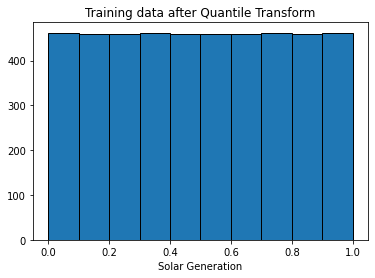

In [13]:
plt.figure()
plt.hist(y_train, edgecolor='black')
plt.title("Training data after Quantile Transform")
plt.xlabel("Solar Generation")
plt.show()

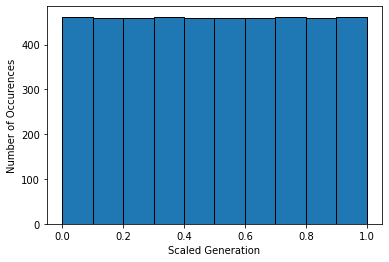

In [14]:
plt.figure()
plt.hist(y_train, edgecolor='black')
# plt.title("Training 'y' distribution")
plt.xlabel('Scaled Generation')
plt.ylabel("Number of Occurences")
plt.show()

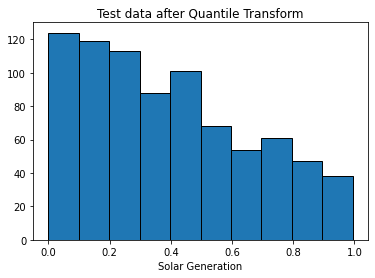

In [15]:
plt.figure()
plt.hist(y_test, edgecolor='black')
plt.xlabel("Solar Generation")
plt.title("Test data after Quantile Transform")
plt.show()

## Fit with KNN
<hr>

In [16]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from math import sqrt


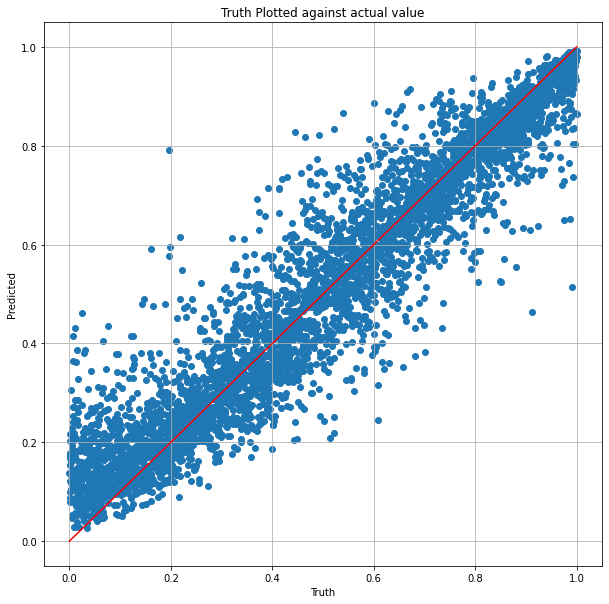

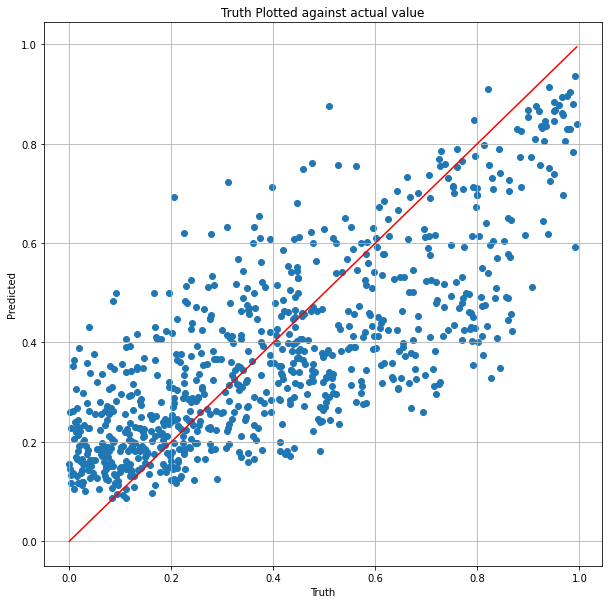

In [17]:
KNNmodel = neighbors.KNeighborsRegressor(n_neighbors = 9)
KNNmodel.fit(x_train, y_train)  #fit the model
test_pred_knn = KNNmodel.predict(x_test) #make prediction on test set
train_pred_knn = KNNmodel.predict(x_train)
plotRegression(y_train, train_pred_knn)
plotRegression(y_test, test_pred_knn)

In [18]:
# print( r2_score(y_train, train_pred_knn) )
# print( r2_score(y_test, test_pred_knn) )

In [19]:
print(score_unscaled(y_train, train_pred_knn))
print(score_unscaled(y_test, test_pred_knn))

{'r2': 0.9052738317281426, 'MAE': 3.18139110407426, 'MSE': 24.613731988323547, 'MedianAE': 1.773637204304972, 'ExpVar': 0.9053920465531677, 'RMSE': 4.961222831956205, 'MAPE': array([0.18995216])}
{'r2': 0.5512293205065552, 'MAE': 6.688088520639615, 'MSE': 89.48510613163364, 'MedianAE': 4.322090277388714, 'ExpVar': 0.5826338127194979, 'RMSE': 9.459656766058357, 'MAPE': array([0.52600051])}


## Try fitting the data with RandomForestRegressors
<hr>

In [20]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(x_train, y_train)

<ipython-input-20-2b30f33dd5bf>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x_train, y_train)


RandomForestRegressor(random_state=0)

In [21]:
# Training data r^2 value 
y_train_pred = regressor.predict(x_train)
r2_score(y_train, y_train_pred)

0.990485350528159

In [22]:
# testing data r^2 value 
y_test_pred = regressor.predict(x_test)
r2_score(y_test, y_test_pred)

0.7830030582584177

In [23]:
print(score_unscaled(y_train, y_train_pred))
print(score_unscaled(y_test,y_test_pred))



{'r2': 0.9870092060017892, 'MAE': 0.9550716295149216, 'MSE': 3.375539490521951, 'MedianAE': 0.4423835429523493, 'ExpVar': 0.9872189649007549, 'RMSE': 1.8372641319423701, 'MAPE': array([0.05293502])}
{'r2': 0.7506084264799563, 'MAE': 4.54047407881538, 'MSE': 49.72880904333281, 'MedianAE': 2.426762949265287, 'ExpVar': 0.7733742814988209, 'RMSE': 7.051865642745387, 'MAPE': array([0.33987584])}


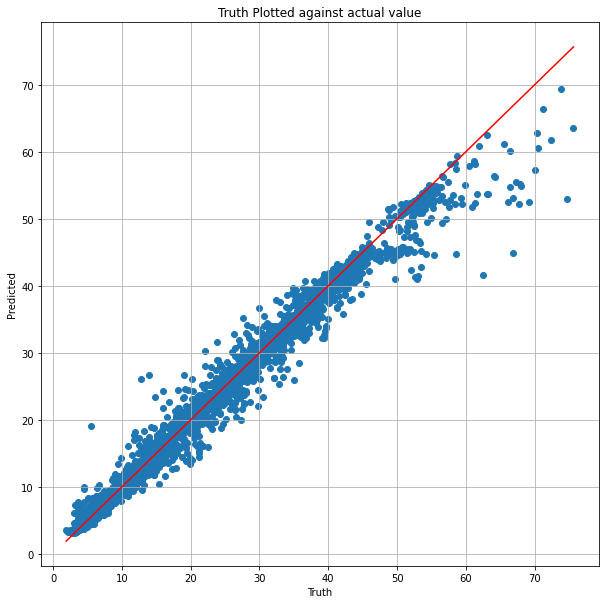

In [24]:
plotRegression(scalerY.inverse_transform(y_train.reshape(-1,1))/1000, scalerY.inverse_transform(y_train_pred.reshape(-1,1))/1000)

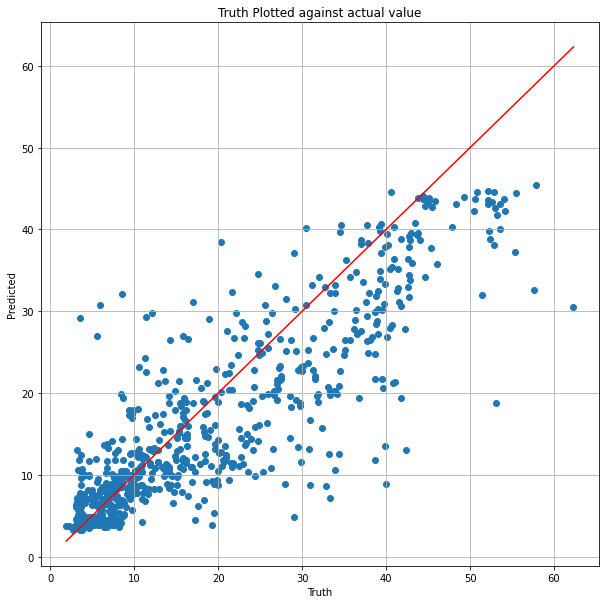

In [25]:
plotRegression(scalerY.inverse_transform(y_test.reshape(-1,1))/1000, scalerY.inverse_transform(y_test_pred.reshape(-1,1))/1000)

## Support Vector Regression 
<hr>

In [26]:
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# x_train = sc_X.fit_transform(x_train)
# x_test = sc_X.fit_transform(x_test)
# y_train = sc_y.fit_transform(y_train)
# y_test = sc_y.fit_transform(y_test)

### Before transform, data has range () after transform, from from (-1,5) (Using Standard scaler)
### Using MinMaxScaler gives range between 0-1


In [27]:
x_train = x_train.reshape(-1, x_train.shape[1],)
x_test = x_test.reshape(-1, x_train.shape[1],)
# Reshape Y 
print('Before reshaping: ')
print(y_train.shape)
print(y_test.shape)

y_train = y_train.flatten()
y_test = y_test.flatten()
print('After reshaping: ')
print(y_train.shape)
print(y_test.shape)

Before reshaping: 
(4603, 1)
(813, 1)
After reshaping: 
(4603,)
(813,)


In [28]:
regressorSVR = SVR(kernel='poly')
regressorSVR.fit(x_train, y_train)

SVR(kernel='poly')

In [29]:
y_train_pred_svr = regressorSVR.predict(x_train)
y_test_pred_svr = regressorSVR.predict(x_test)

In [30]:
print(r2_score(y_train, y_train_pred_svr))
print(r2_score(y_test, y_test_pred_svr))

0.9400780239039489
0.7105303903861987


In [31]:
print(score_unscaled(y_train, y_train_pred_svr))
print(score_unscaled(y_test, y_test_pred_svr))

{'r2': 0.9220520596450281, 'MAE': 2.883998293965132, 'MSE': 20.254062292827996, 'MedianAE': 1.8382803070976124, 'ExpVar': 0.922905035474525, 'RMSE': 4.5004513432352535, 'MAPE': array([0.16215649])}
{'r2': 0.6671014863394984, 'MAE': 5.621739950044357, 'MSE': 66.38013619695091, 'MedianAE': 3.43399157927524, 'ExpVar': 0.7448293434475921, 'RMSE': 8.147400579138779, 'MAPE': array([0.4565809])}


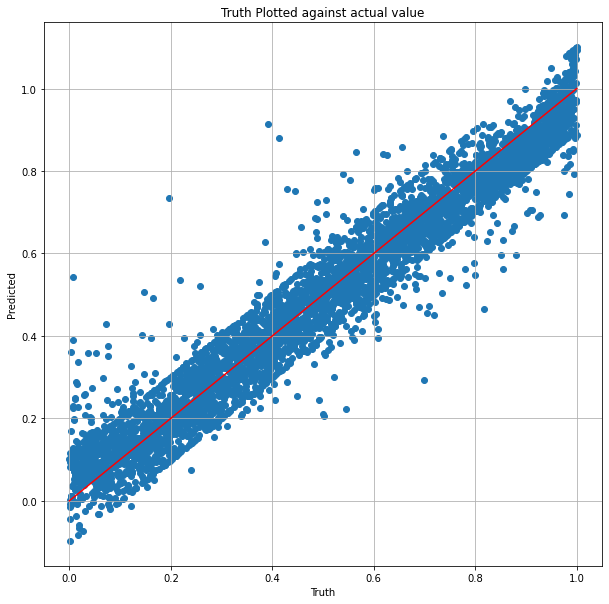

In [32]:
plotRegression(truth=y_train, pred=y_train_pred_svr)

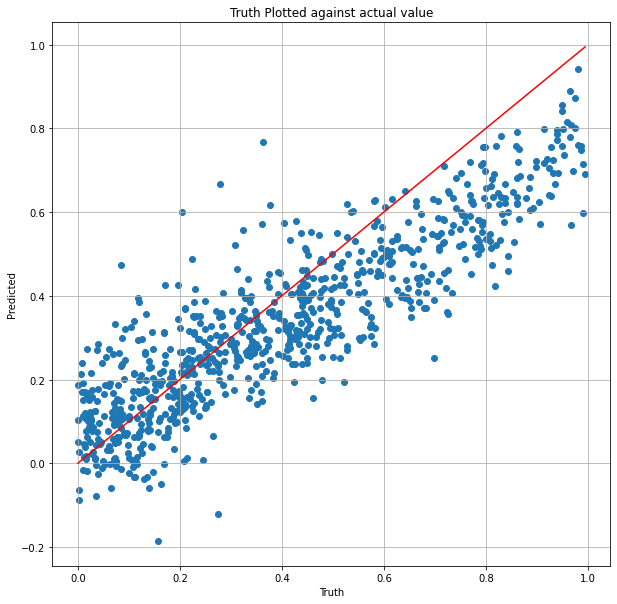

In [33]:
plotRegression(truth=y_test, pred=y_test_pred_svr)

## Using keras RNN and ANN
<hr>

In [34]:
import tensorflow as tf 
from tensorflow import keras
from keras import backend as K
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.layers.experimental import preprocessing

In [35]:
# not sure if this is right. 
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [36]:
# x_train = x_train.reshape(-1,x_train.shape[1],)
# x_test = x_test.reshape(-1,x_train.shape[1],)
# scalerX = MinMaxScaler()
# scalerX.fit(x_train)
# x_train = scalerX.transform(x_train)
# x_test = scalerX.transform(x_test)

In [37]:
#LSTM model
model = Sequential()
model.add(LSTM(10, input_shape=(x_train.shape[1],1), return_sequences=True))
model.add(Dropout(0.2))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
# optimizer 
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-5)
# compile
# mean_squared_error
# mean_absolute_error
model.compile(loss='mean_absolute_error', optimizer=opt, metrics=[coeff_determination])

In [38]:
def plot_loss(history):
  plt.figure()
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()
  plt.figure()
  plt.plot(history.history['coeff_determination'], label='R^2')
  plt.plot(history.history['val_coeff_determination'], label='validation R^2')
  plt.xlabel('Epoch')
  plt.ylabel('R^2')
  plt.legend()
  plt.show()

In [39]:
x_train = x_train.reshape(-1,x_train.shape[1],1)
x_test = x_test.reshape(-1,x_train.shape[1],1)

In [40]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

oeff_determination: 0.7375 - val_loss: 0.1485 - val_coeff_determination: 0.4123
Epoch 131/250
72/72 [==============================] - 1s 18ms/step - loss: 0.1118 - coeff_determination: 0.7362 - val_loss: 0.1506 - val_coeff_determination: 0.3987
Epoch 132/250
72/72 [==============================] - 1s 18ms/step - loss: 0.1157 - coeff_determination: 0.7230 - val_loss: 0.1485 - val_coeff_determination: 0.4130
Epoch 133/250
72/72 [==============================] - 1s 18ms/step - loss: 0.1128 - coeff_determination: 0.7368 - val_loss: 0.1476 - val_coeff_determination: 0.4227
Epoch 134/250
72/72 [==============================] - 1s 18ms/step - loss: 0.1130 - coeff_determination: 0.7368 - val_loss: 0.1487 - val_coeff_determination: 0.4200
Epoch 135/250
72/72 [==============================] - 1s 18ms/step - loss: 0.1127 - coeff_determination: 0.7399 - val_loss: 0.1477 - val_coeff_determination: 0.4216
Epoch 136/250
72/72 [==============================] - 1s 18ms/step - loss: 0.1135 - coeff

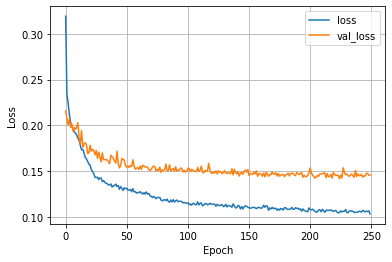

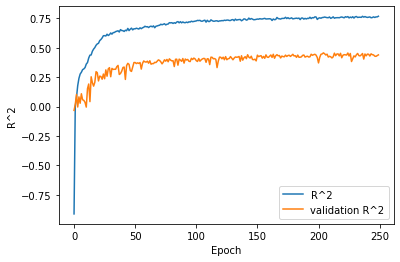

In [41]:
history= model.fit(x=x_train, y=y_train, epochs=250, validation_data=(x_test, y_test),batch_size=64,verbose=1)
plot_loss(history)

In [42]:
model.save(f"/Users/brad/Desktop/CS6620/Project/models/rnn_model{str(datetime.now())}.h5")

In [43]:
y_pred_train_LSTM = model.predict(x_train)
print(r2_score(y_train, y_pred_train_LSTM))
y_pred_test_LSTM = model.predict(x_test)
print(r2_score(y_test, y_pred_test_LSTM))

0.8031427972198448
0.544151498567372


In [44]:
print(score_unscaled(y_train, y_pred_train_LSTM))
print(score_unscaled(y_test, y_pred_test_LSTM))

{'r2': 0.7812743431556834, 'MAE': 5.402553957672352, 'MSE': 56.83386961336095, 'MedianAE': 3.770578170693188, 'ExpVar': 0.8107634369581895, 'RMSE': 7.538824153232449, 'MAPE': array([0.30180622])}
{'r2': 0.48135298147810224, 'MAE': 7.245446119107887, 'MSE': 103.41848435747752, 'MedianAE': 4.537781627690535, 'ExpVar': 0.5329757854376687, 'RMSE': 10.1694879102872, 'MAPE': array([0.54111019])}


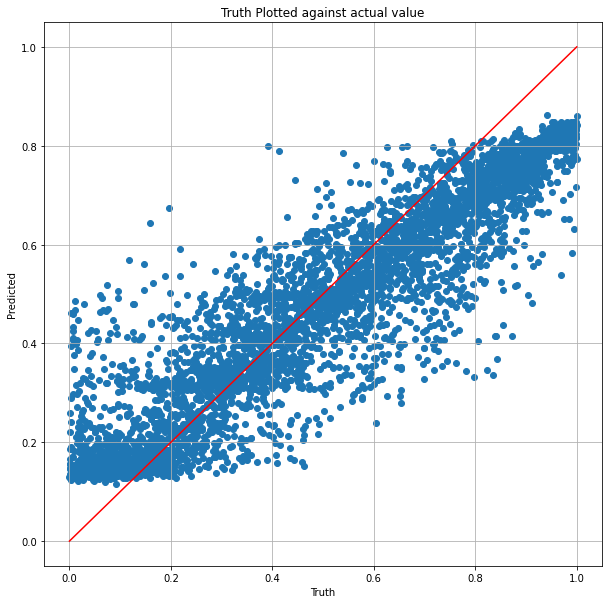

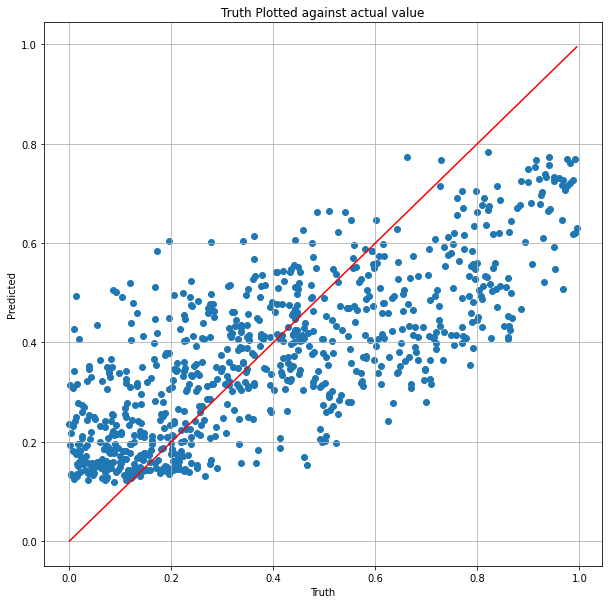

In [45]:
plotRegression(y_train, y_pred_train_LSTM)
plotRegression(y_test, y_pred_test_LSTM)

In [46]:
# ann Model
ann_model = Sequential()
ann_model.add(Dense(20, input_dim=x_train.shape[1], activation='relu'))
ann_model.add(Dropout(0.2))
ann_model.add(Dense(10, activation='relu'))
ann_model.add(Dropout(0.2))
# ann_model.add(Dense(10, activation='relu'))
# ann_model.add(Dropout(0.2))
# ann_model.add(Dense(10, activation='relu'))
ann_model.add(Dense(1, activation='relu'))
# optimizer 
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# compile
# mean_squared_error
# mean_absolute_error
ann_model.compile(loss='mean_absolute_error', optimizer=opt, metrics=[coeff_determination])

In [59]:
History = ann_model.fit(x=x_train.reshape(-1,x_train.shape[1], ), y=y_train.reshape(-1,), epochs=400, validation_data=(x_test.reshape(-1,x_train.shape[1], ), y_test.reshape(-1,)),batch_size=50,verbose=0)

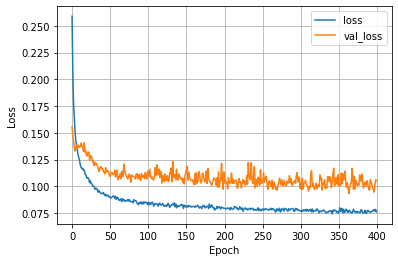

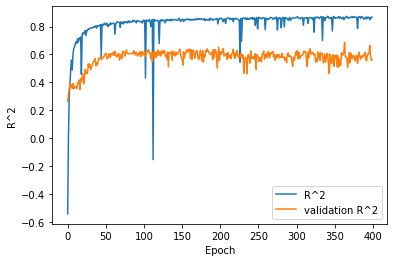

In [48]:
plot_loss(History)

num = 0
while num < 10:
    history= ann_model.fit(x=x_train.reshape(-1,x_train.shape[1], ), y=y_train.reshape(-1,), epochs=100, validation_data=(x_test.reshape(-1,x_train.shape[1], ), y_test.reshape(-1,)),batch_size=64,verbose=0)
    plot_loss(history)
    y_pred_train_ann = model.predict(x_train)
    print(r2_score(y_train, y_pred_train_ann))
    y_pred_test_ann = model.predict(x_test)
    print(r2_score(y_test, y_pred_test_ann))
    num += 1


In [60]:
y_pred_train_ann = ann_model.predict(x_train.reshape(-1,x_train.shape[1], ))
print(r2_score(y_train, y_pred_train_ann))
y_pred_test_ann = ann_model.predict(x_test.reshape(-1,x_train.shape[1], ))
print(r2_score(y_test, y_pred_test_ann))

0.9157140240039618
0.7176300979896358


In [61]:
print(score_unscaled(y_train, y_pred_train_ann))
print(score_unscaled(y_test, y_pred_test_ann))

{'r2': 0.9005093137606321, 'MAE': 3.4265288978811093, 'MSE': 25.85174858337141, 'MedianAE': 2.1536653714540783, 'ExpVar': 0.9106263584038662, 'RMSE': 5.084461484107379, 'MAPE': array([0.23176165])}
{'r2': 0.7401728810038434, 'MAE': 4.709376460439493, 'MSE': 51.80966222100814, 'MedianAE': 2.6640798248044923, 'ExpVar': 0.763345767214009, 'RMSE': 7.197892901468328, 'MAPE': array([0.56295464])}


In [51]:
ann_model.save(f"/Users/brad/Desktop/CS6620/Project/models/ann_model{str(datetime.now())}.h5")

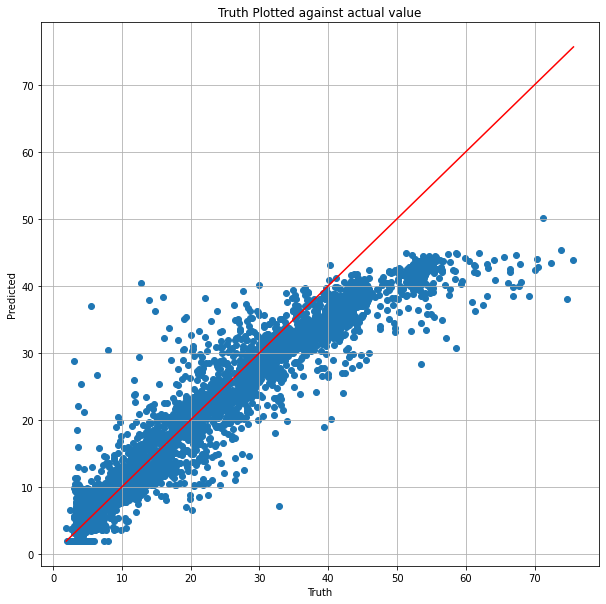

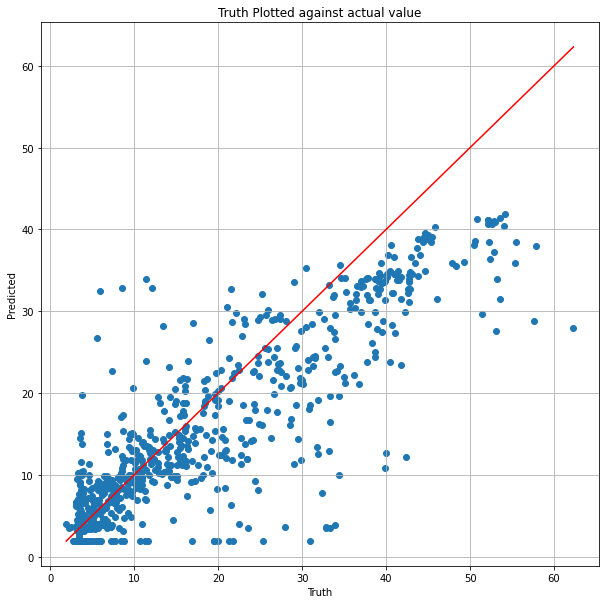

In [52]:
plotRegression(scalerY.inverse_transform(y_train.reshape(-1,1))/1000, scalerY.inverse_transform(y_pred_train_ann.reshape(-1,1))/1000)
plotRegression(scalerY.inverse_transform(y_test.reshape(-1,1))/1000, scalerY.inverse_transform(y_pred_test_ann.reshape(-1,1))/1000)